In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random

In [2]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'dataset/images/'
label_path = 'dataset/labels/'
image_names = os.listdir(label_path)

-27_-105_h
6_-101_h
1_-121


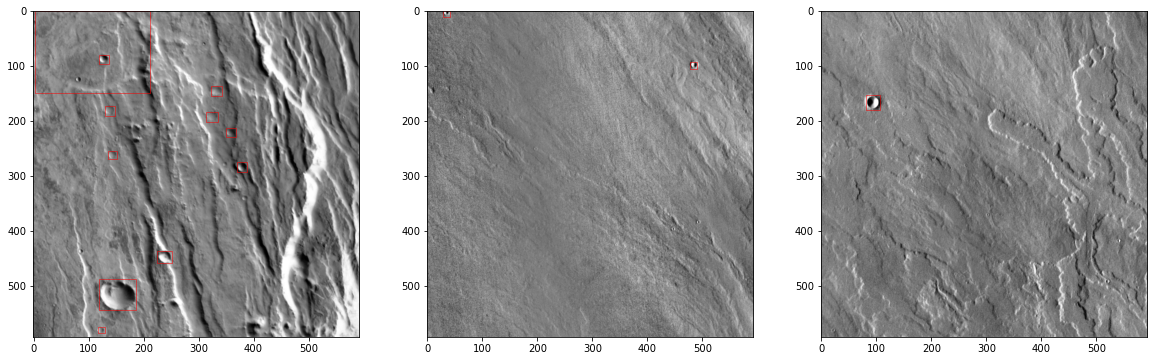

In [3]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    image_name = image_names[i][:-4]
    im = Image.open(image_path + image_name + '.png')
    ax[i].imshow(im, cmap='gray')
    size, size = im.size
    label_name = image_name + '.txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h, id = line.split(' ')
        x = float(x) * size
        y = float(y) * size
        w = float(w) * size
        h = float(h) * size
        x -= w / 2
        y -= h / 2
        rect = patches.Rectangle((x, y), w, h, linewidth=0.5, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    f.close()

In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_list = os.listdir('dataset/images')

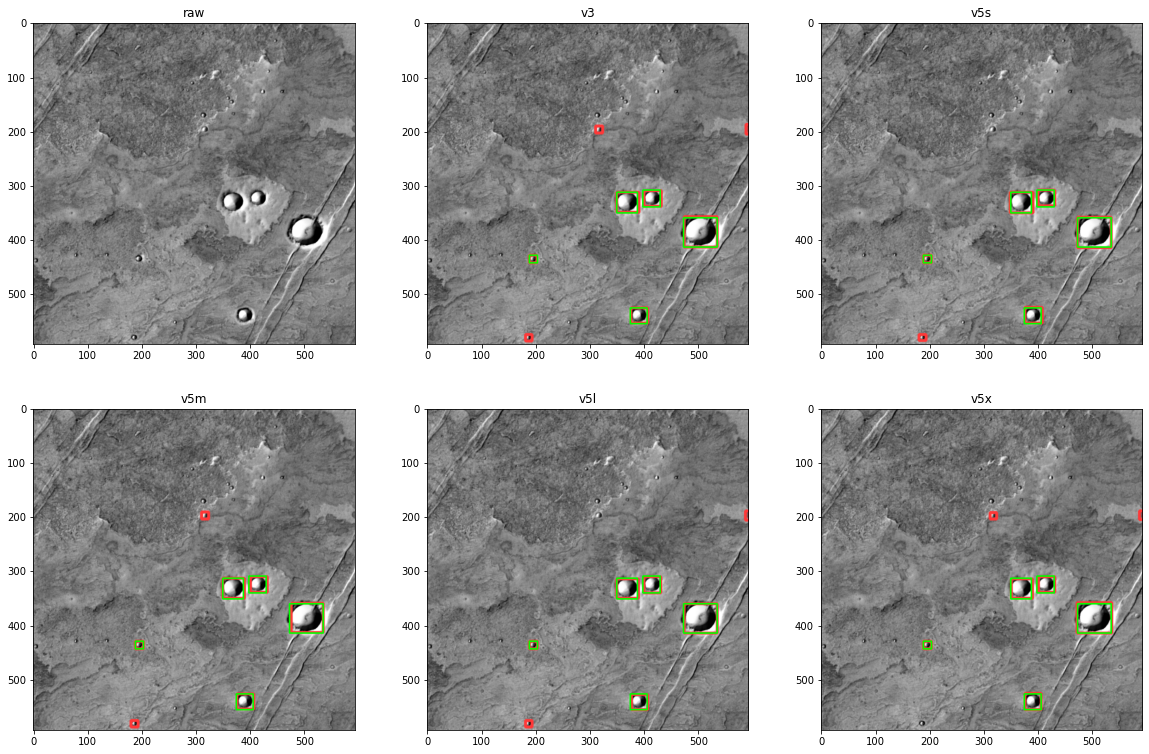

In [39]:
random.shuffle(image_list)
for image_name in image_list[:1]:
    plt.figure(figsize=(20, 13))

    # origin pic
    plt.subplot(2, 3, 1)
    raw_pic = mpimg.imread('dataset/images/' + image_name)
    plt.imshow(raw_pic, cmap='gray')
    plt.title('raw')

    # v3
    plt.subplot(2, 3, 2)
    pic = mpimg.imread('detect/v3/' + image_name)
    plt.imshow(pic)
    plt.title('v3')

    # v5s
    plt.subplot(2, 3, 3)
    pic = mpimg.imread('detect/v5s/' + image_name)
    plt.imshow(pic)
    plt.title('v5s')

    # v5m
    plt.subplot(2, 3, 4)
    pic = mpimg.imread('detect/v5m/' + image_name)
    plt.imshow(pic)
    plt.title('v5m')

    # v5l
    plt.subplot(2, 3, 5)
    pic = mpimg.imread('detect/v5l/' + image_name)
    plt.imshow(pic)
    plt.title('v5l')

    # v5x
    plt.subplot(2, 3, 6)
    pic = mpimg.imread('detect/v5x/' + image_name)
    plt.imshow(pic)
    plt.title('v5x')